In [2]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from tqdm import tqdm

# tsdata saved in ../data/time_series_data/
# images saved in ../results/newtsdata

days=1460 # (4 years = 1460 days)
year=2018 # start of time series data

data_columns = ['idle_time','bike_count']

In [ ]:
df = pd.read_csv('../../data/final_df_points_18_21_class.csv')
df['time_start'] = pd.to_datetime(df['dt_start'],unit='s')
df.head()

In [12]:
# DEFINE TIME SERIES RANGE
# sets the data as index of time series (ts) data

rng = pd.date_range(f'{year}-01-01', periods=days, freq='D')
tsdata = pd.DataFrame({ 'date': rng, 'idle_time' : np.nan,  'bike_count': np.nan})
tsdata = tsdata.set_index('date')
tsdata.head()

,idle_time,bike_count
date,,
2018-01-01,NaN,NaN
2018-01-02,NaN,NaN
2018-01-03,NaN,NaN
2018-01-04,NaN,NaN
2018-01-05,NaN,NaN


In [22]:
# GET ALL RENTALS FORM HEX_ID
def get_all_rentals(hex_id):
    onedfhexid = df[df['hex_id']==hex_id]
    return onedfhexid.reset_index(drop=True)

In [23]:
def add_rows_to_days(onedfhexid):
    # ADD ROWS TO DAYS
    # compute idle time mean for one day over all rentals at that day

    # iteriere über alle Tage
    for date in tqdm(tsdata.index):
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in onedfhexid.index:
            if date.date() == onedfhexid['time_start'][ind].date():
                list.append(onedfhexid['idle_time'][ind])
        #print(len(list))
        # Setze Mittelwert für Tage
        if len(list) == 0:
            tsdata['bike_count'][date] = 1
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [24]:
# FILL MISSING DATA
def fill_missing_data(tsdata):
    tsdata = tsdata.asfreq('D')
    tsdata = tsdata.ffill()
    return tsdata

In [25]:
# TOTAL BIKE COUNT
def total_bike_count(tsdata):
    total_bike_count = int(tsdata['bike_count'].sum())
    return total_bike_count

In [47]:
# CREATE ROLLING WINDOW WITH MEAN
def roling_mean(tsdata):
    data_7d_rol = tsdata[data_columns].rolling(window = 7, center = True).mean()
    data_2m_rol = tsdata[data_columns].rolling(window = 60, center = True).mean()
    return data_7d_rol, data_2m_rol

In [48]:
# CREATE ROLLING WEIGHTED MEAN
def rolling_weightet_mean(tsdata):
    x = []
    rng2 = pd.date_range(f'{year}-01-01', periods=days, freq='D')
    data_7d_rol_w = pd.DataFrame({ 'date': rng2, 'idle_time' : np.nan})
    data_7d_rol_w = data_7d_rol_w.set_index('date')

    for window in tsdata.rolling(window = 7 , center = True):
        #print(window)
        x.append(np.average(window['idle_time'], weights = window['bike_count']))
    data_7d_rol_w['idle_time'] = x
    return data_7d_rol_w

In [71]:
import pickle

def plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count):

    fig, ax = plt.subplots(figsize = (17,6))

    # plotting daily data
    # plotting 7-day rolling data
    #ax.plot(data_7d_rol['idle_time'],color = 'blue', linewidth=2, label='7-d Rolling Mean')
    d7 = ax.plot(data_7d_mean2['idle_time'],color = 'green', linewidth=2, label='7D Rolling Mean der Standzeit')
    # plotting 2-Month rolling data -trend-
    m2 = ax.plot(data_2m_rol['idle_time'], color='0.2', linewidth=3, label='2M Trend der Standzeit')
    d1 = ax.plot(tsdata['idle_time'], marker='.', markersize=2, color='0.6',linestyle='None', label='Tägliche Standzeit')

    ax2 = ax.twinx()
    bc = ax2.plot(data_7d_rol['bike_count'],linewidth=1, color='0.5',label='7D Rolling Mean Fahrradanzahl')

    # added these three lines
    all = d1+d7+m2+bc
    labs = [l.get_label() for l in all]
    ax.legend(all, labs, loc="upper right")

    #ax.set_title(f'Trends der Standzeit von Fahrrädern im H3-Hexagon {hex_id} mit einer totalen Anzahl von {total_bike_count} Standpunkten über 4 Jahre')
    ax.set_xlabel('Tag')
    ax.set_ylabel('Mittlere Stadzeit in Minuten')
    ax2.set_ylabel('Standpunkte im Hexagon pro Tag')

    ## SAVE

    #create a file
    #picklefile = open(f'../data/time_series_data/tsdata_{hex_id}', 'wb')
    #pickle the dataframe
    #pickle.dump(tsdata, picklefile)
    #close file
    #picklefile.close()

    plt.savefig(f'../../results/time_series_data/tsdata_{hex_id}-new.png', format='png')
    #plt.show()

In [ ]:
_hex_id = '881f1a8cb7fffff'
_onedfhexid = get_all_rentals(_hex_id)
_tsdata = add_rows_to_days(_onedfhexid)
_tsdata = fill_missing_data(_tsdata)
_tbc = total_bike_count(_tsdata)
_data_7d_rol, _data_2m_rol, data_6m_rol = roling_mean(_tsdata)
_data_7d_rol2 = rolling_weightet_mean(_tsdata)
plot_details(_tsdata,_data_7d_rol,_data_2m_rol,_data_7d_rol2,data_6m_rol,_hex_id,_tbc)

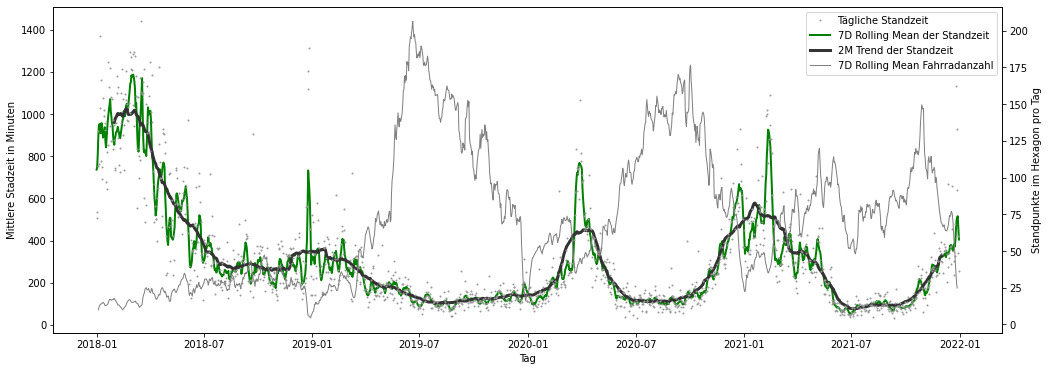

In [72]:
_data_7d_rol, _data_2m_rol = roling_mean(_tsdata)
_data_7d_rol2 = rolling_weightet_mean(_tsdata)
_tbc = total_bike_count(_tsdata)

plot_details(_tsdata,_data_7d_rol,_data_2m_rol,_data_7d_rol2,_hex_id,_tbc)


### Compute tsdata for every unique hexagon

hex_ids = df.hex_id.unique()
i = 0
total = len(hex_ids)

for _hex_id in hex_ids:
    _onedfhexid = get_all_rentals(_hex_id)
    _tsdata = add_rows_to_days(_onedfhexid)
    _tsdata = fill_missing_data(_tsdata)
    _tbc = total_bike_count(_tsdata)
    _data_7d_rol, _data_2m_rol = roling_mean(_tsdata)
    _data_7d_rol2 = rolling_weightet_mean(_tsdata)
    plot_details(_tsdata,_data_7d_rol,_data_2m_rol,_data_7d_rol2,_hex_id,_tbc)
    i+=1
    print(f'{i} from {total}', end='\r')